In [41]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

from resnet import ResNet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available()

True

In [2]:
CIFAR10_TRAIN_MEAN = (0.49139968, 0.48215827, 0.44653124)
CIFAR10_TRAIN_STD = (0.24703233, 0.24348505, 0.26158768)

BATCH_SIZE = 64
CLASSES = 10

mean = CIFAR10_TRAIN_MEAN
std = CIFAR10_TRAIN_STD

train_transformer = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean, std)
])

test_transformer = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean, std)
])

train_ds = CIFAR10(root='../datasets', train=True, download=True, transform=train_transformer)
test_ds = CIFAR10(root='../datasets', train=False, download=True, transform=test_transformer)
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
classes = 10

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
model = ResNet18(classes = classes).to(device)
model.to(device)
model.load_state_dict(torch.load('../models/epoch39_train0.98982_test0.9154.pt'))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [4]:
for param in model.parameters():
    param.requires_grad = False

In [5]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

11,173,962 total parameters.
0 training parameters.


In [6]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [16]:
candidates = ['bn1', 'layer1', 'layer2', 'layer3', 'layer4']

benchmarks = dict()
count_dict = dict()
for l in range(len(candidates)):
    benchmarks[l] = {'pos':dict(), 'neg':dict()}
    count_dict[l] = {'pos':dict(), 'neg':dict()}
    for c in range(CLASSES):
        benchmarks[l]['pos'][c] = None
        benchmarks[l]['neg'][c] = None
        count_dict[l]['pos'][c] = 0
        count_dict[l]['neg'][c] = 0

with tqdm(train_loader, unit="batch") as tepoch:
    for xtrain, ytrain in tepoch:       
        for l, lname in enumerate(candidates):
            if l == 0:
                model.bn1.register_forward_hook(get_activation(lname))
            elif l == 1:
                model.layer1.register_forward_hook(get_activation(lname))
            elif l == 2:
                model.layer2.register_forward_hook(get_activation(lname))
            elif l == 3:
                model.layer3.register_forward_hook(get_activation(lname))
            elif l == 4:
                model.layer4.register_forward_hook(get_activation(lname))
            
            xtrain = xtrain.to(device)
            output = model(xtrain)
            test_pred = torch.max(output.cpu(),1).indices
            
            features = activation[lname].cpu().detach().numpy()  # shape: [b, c, w, h]

            for i in range(features.shape[0]):  # for each feature in a batch
                c = int(ytrain[i])
                if(test_pred[i] == ytrain[i]):  # only keep positive features maps, take its mean, no outliers considered
                    if benchmarks[l]['pos'][c] is None:
                        benchmarks[l]['pos'][c] = features[i]
                        count_dict[l]['pos'][c] = 1
                    else:
                        benchmarks[l]['pos'][c] = (benchmarks[l]['pos'][c] * count_dict[l]['pos'][c] + features[i]) / (count_dict[l]['pos'][c] + 1)
                        count_dict[l]['pos'][c] += 1
                else:
                    if benchmarks[l]['neg'][c] is None:
                        benchmarks[l]['neg'][c] = features[i]
                        count_dict[l]['neg'][c] = 1
                    else:
                        benchmarks[l]['neg'][c] = (benchmarks[l]['neg'][c] * count_dict[l]['neg'][c] + features[i]) / (count_dict[l]['neg'][c] + 1)
                        count_dict[l]['neg'][c] += 1

100%|██████████| 782/782 [02:07<00:00,  6.14batch/s]


In [57]:
def distance(benchmark, feature_map, method='L2', norm=True):
    benchmark = np.ravel(benchmark).reshape(-1, 1)
    feature_map = np.ravel(feature_map).reshape(-1, 1)
    
    if norm is True:
        scaler = StandardScaler()
        benchmark = scaler.fit_transform(benchmark)
        feature_map = scaler.fit_transform(feature_map)

    if method == 'L2':
        dis = np.linalg.norm(benchmark - feature_map)
        return dis
    
    raise Exception("No designated method found.")

In [58]:
sim_dict = dict()
for l in range(len(candidates)):
    sim_dict[l] = {'pos': dict(), 'neg': dict()}
    for c in range(CLASSES):
        sim_dict[l]['pos'][c] = []
        sim_dict[l]['neg'][c] = []

with tqdm(test_loader, unit="batch") as tepoch:
    for xtest, ytest in tepoch:              
        for l, lname in enumerate(candidates):
            if l == 0:
                model.bn1.register_forward_hook(get_activation(lname))
            elif l == 1:
                model.layer1.register_forward_hook(get_activation(lname))
            elif l == 2:
                model.layer2.register_forward_hook(get_activation(lname))
            elif l == 3:
                model.layer3.register_forward_hook(get_activation(lname))
            elif l == 4:
                model.layer4.register_forward_hook(get_activation(lname))
        
            xtest = xtest.to(device)
            output = model(xtest)
            test_pred = torch.max(output.cpu(),1).indices
            
            features = activation[lname].cpu().detach().numpy()
            
            for i in range(xtest.shape[0]):
                c = int(ytest[i])
                dis = distance(benchmarks[l]['pos'][c], features[i], 'L2')
                
                sim = 1 / dis
                
                if(test_pred[i] == ytest[i]):
                    sim_dict[l]['pos'][c].append(sim)
                else:
                    sim_dict[l]['neg'][c].append(sim)

100%|██████████| 157/157 [01:32<00:00,  1.69batch/s]


In [59]:
def bhatta_dist(X1, X2):

    def get_density(x, cov_factor=0.1):
        density = gaussian_kde(x)
        density.covariance_factor = lambda:cov_factor
        density._compute_covariance()
        return density
    
    n_steps = max(X1.shape[1], X2.shape[1]) * 2

    d1 = get_density(X1)
    d2 = get_density(X2)

    cX = np.hstack((X1,X2))
    xs = np.linspace(np.min(cX),np.max(cX),n_steps)
    bht = 0

    for x in xs:
        p1 = d1(x)
        p2 = d2(x)
        bht += np.sqrt(p1*p2)*(np.max(cX)-np.min(cX))/n_steps
    
    return -np.log(bht) if bht != 0 else float('Inf')

100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


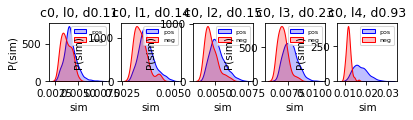

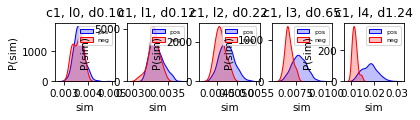

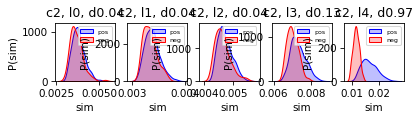

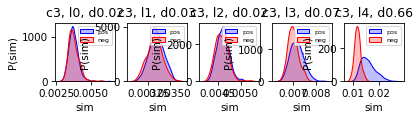

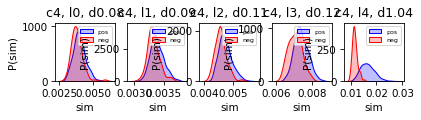

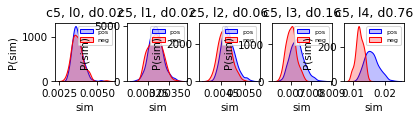

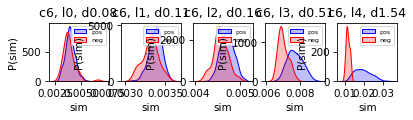

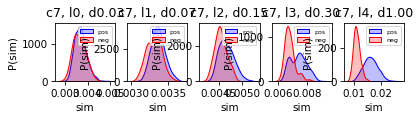

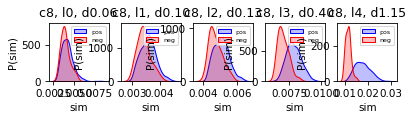

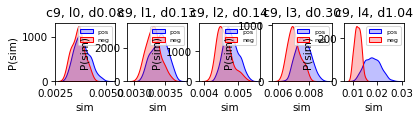

In [61]:
for c in tqdm(range(CLASSES)):
    fig = plt.figure(figsize=(6, 1), dpi=75)
    for l in range(len(candidates)):
        
        pos_data = sim_dict[l]['pos'][c]
        neg_data = sim_dict[l]['neg'][c]
        
        dis = bhatta_dist(np.array(pos_data).reshape(1, -1), np.array(neg_data).reshape(1, -1))

        plt.subplot(1, len(candidates), l+1)
        ax = sns.kdeplot(pos_data, color="Blue", fill = True)
        ax = sns.kdeplot(neg_data, ax=ax, color="Red", fill= True)
        ax.legend(["pos","neg"],loc='upper right',prop={'size': 6})
        ax.set_ylabel('P(sim)')
        ax.set_xlabel('sim')
        ax.set_title('c%d, l%d, d%.2f' % (c, l, dis))

In [62]:
rlb_dict = dict()
for l in range(len(candidates)):
    reliability = 0
    for c in range(CLASSES):
        pos_data = np.array(sim_dict[l]['pos'][c]).reshape(1, -1)
        neg_data = np.array(sim_dict[l]['neg'][c]).reshape(1, -1)
        bha = bhatta_dist(pos_data, neg_data)
        reliability += bha
    rlb_dict[l] = reliability

rlb_dict

{0: array([0.63023658]),
 1: array([0.84839339]),
 2: array([1.18259073]),
 3: array([2.87398902]),
 4: array([10.3410352])}